# World Happiness Report - Data Exploration

In this notebook we will use the Kaggle dataset World Happiness Report which compiles the data from 2015-2019 analysis published by United Nation based on Gallup World Poll survery results from 2014-2018. 

The happiness scores are based on answers to the main life evaluation question asked in the poll. This question, known as the Cantril ladder, asks respondents to think of a ladder with the best possible life for them being a 10 and the worst possible life being a 0 and to rate their own current lives on that scale.

The scores are from nationally representative samples and use the Gallup weights to make the estimates representative. The columns following the happiness score estimate the extent (later referred as Components) to which each of six factors – economic production, social support, life expectancy, freedom, absence of corruption, and generosity – contribute to making life evaluations higher in each country than they are in Dystopia, a hypothetical country that has values equal to the world’s lowest national averages for each of the six factors. They have no impact on the total score reported for each country, but they do explain why some countries rank higher than others.

After cleaning the data, we will look into the rankings and changes throughout year on the happiness score. Then we will focus on 2018 survey results. 

Since the happiness score was calculated by adding six components as well as some unique country factors that were not mentioned, using these components for modelling will not be so accurate. At the end of this notebook, we will combine the happiness scores for 5 years to one dataframe for later analysis together with some national level indicators we selected based on Maslow's pyramid of needs.

### Approaches: 
0. Read and load data


1. Data Cleaning and Manupulation
 - 1.1 Rename main columns
 - 1.2 Add new columns indicating regions and continent
 - 1.3 Align country names
 - 1.4 Handle missing values and duplicates
 
 
2. Data Exploration 
 - 2.1 Year-to-Year comparison
     - 2.1.1 
 [Top and bottom ranks of happiest countries from 2014-2018](#2.1.1Top-&-bottom-ranks-2015-2018)
     - 2.1.2 
 [Changes of happiness scores between 2014 and 2018](#2.1.2-Changes-of-happiness-scores-between-2014-and-2018)
 - 2.2 Visualization on 2018 result
      - 2.2.1 
 [Distributions of happiness score in regions](#2.2.1-Distributions-of-happiness-score-in-regions)
      - 2.2.2 
 [Relationships between components](#2.2.2-Relationships-between-components)
      - 2.2.3
 [Happiness on Map](#2.2.3-Happiness-on-Map)
 
 
3. Combine all dataframes
  - Export to csv file 

In [1]:
import pandas as pd
import numpy as np

import altair as alt
alt.renderers.enable('notebook')

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

import seaborn as sns
sns.set_context('talk', font_scale=0.8)
sns.set_style('whitegrid')


import plotly as py
from plotly import tools
from plotly import subplots
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

%matplotlib inline


## 0. Load files and read data

- Dataset from Kaggle contains in total 5 csv files.
- The csv files' names represent the year of survey publication for the result from previous year.
- We will rename the data frame under its survey year. 

In [2]:
# define a function to load all data into a dictionary
def load_csv(startyear,endyear):
    df = {}

    year_files = range(startyear,endyear+1)

    for year in year_files:
        # read data
        df[year-1]=pd.read_csv(f'./data/whi/{year}.csv')
        # assign 'Year' column to each data frame to indicate survery year
        df[year-1]=df[year-1].assign(Year=year-1)   
    return df

In [3]:
# Load data
df = load_csv(2015,2019)

In [4]:
df[2016].head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual,Year
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,2016
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,2016
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715,2016
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716,2016
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182,2016


## 1. Data cleaning and Manipulations

### 1.1 Rename main columns

In [5]:
# Dataframe from each year has slightly different column names
# Country, Happiness rank and Happiness score will be used for later comparison
# Rename columns so the above columns will have the same names
    
years=range(2014,2019)
    
for year in years:
    df[year].rename(columns={df[year].filter(regex='ountry').columns[0]: 'Country', 
                             df[year].filter(regex='ank').columns[0]: 'Happiness rank',
                             df[year].filter(regex='core').columns[0]: 'Happiness score'},inplace=True)
      

In [6]:
df[2014].head()

,Country,Region,Happiness rank,Happiness score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2014
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2014
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2014
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2014
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2014


### 1.2 Add new columns indicating regions and continent

In [7]:
# Import python package country_converter
import country_converter as coco

years=range(2014,2019)

for year in years:
    countries = df[year]['Country'].tolist()
    
    converter = coco.CountryConverter()
    
    df[year]['Region'] = converter.convert(names = countries, src = 'regex', to = 'unregion')
    df[year]['Continent'] = converter.convert(names = countries, src = 'regex', to = 'continent')
    
    # Rearrange columns
    df[year] = df[year].set_index(['Year','Continent','Region','Country']).reset_index()

In [8]:
df[2015].head()

,Year,Continent,Region,Country,Happiness rank,Happiness score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,2015,Europe,Northern Europe,Denmark,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,2015,Europe,Western Europe,Switzerland,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,2015,Europe,Northern Europe,Iceland,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,2015,Europe,Northern Europe,Norway,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,2015,Europe,Northern Europe,Finland,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


### 1.3 Align country names
- Country names in each year are slight different. 
- We will use also country_converter package to align all country names throughout the year

In [9]:
years=range(2014,2019)

for year in years:
    countries = df[year]['Country'].tolist()

    converter = coco.CountryConverter()
    df[year]['Country'] = converter.convert(names = countries, src = 'regex', to = 'name_short')

In [10]:
df[2014].head()

,Year,Continent,Region,Country,Happiness rank,Happiness score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,2014,Europe,Western Europe,Switzerland,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,2014,Europe,Northern Europe,Iceland,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,2014,Europe,Northern Europe,Denmark,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,2014,Europe,Northern Europe,Norway,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,2014,America,Northern America,Canada,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


## 1.4 Handle missing values and duplicates

### - Missing Values

In [11]:
# There is a missing value in 2017
years=range(2014,2019)

for year in years: 
    print(year,df[year].isnull().sum().value_counts())  

2014 0    14
dtype: int64
2015 0    15
dtype: int64
2016 0    15
dtype: int64
2017 0    11
1     1
dtype: int64
2018 0    12
dtype: int64


In [12]:
# The missing value is perception of corruption in UAE in 2017
df[2017][df[2017].isnull().any(axis=1)]

,Year,Continent,Region,Country,Happiness rank,Happiness score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
19,2017,Asia,Western Asia,United Arab Emirates,20,6.774,2.096,0.776,0.67,0.284,0.186,NaN


In [13]:
# We will take the value in 2018 since perception of corruption was not measured in 2016

df[2017].loc[19,'Perceptions of corruption']= df[2018][df[2018]['Country']=='United Arab Emirates']['Perceptions of corruption'].values[0]

### - Duplicates

In [14]:
# Cyprus and Somalia are duplicated as happiness report contains also their subregions.
# Country converter converted the subregion to its country name. 
for year in years:
    print(df[year][df[year].duplicated(subset=['Country','Year'],keep='first')][['Country','Happiness rank']])

   Country  Happiness rank
66  Cyprus              67
    Country  Happiness rank
68   Cyprus              69
96  Somalia              97
   Country  Happiness rank
64  Cyprus              65
   Country  Happiness rank
60  Cyprus              61
   Country  Happiness rank
63  Cyprus              64


In [15]:
# Drop the lower ranking and reset index
for year in years:
    df[year] = (df[year].drop(df[year][df[year].duplicated(subset=['Country','Year'],keep='first')].index)
                .reset_index(drop=True))

In [16]:
df[2018][df[2018]['Continent']=='Oceania']['Happiness score']

7     7.307
10    7.228
Name: Happiness score, dtype: float64

## 2. Data Exploration 

### 2.1 Year-to-Year comparison

#### Avearge mean of global happiness score

In [17]:
happiness_score_dict={}

for year in range(2014,2019):
    happiness_score_dict[year]= df[year].filter(regex='(ear|core)')
    happiness_score = pd.concat(happiness_score_dict.values(), ignore_index=True)

happiness_score.groupby('Year').mean().reset_index()

,Year,Happiness score
0,2014,5.373739
1,2015,5.383226
2,2016,5.352286
3,2017,5.373426
4,2018,5.405090


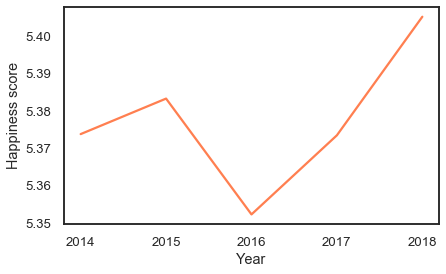

In [18]:
sns.set_style('white')
g = sns.lineplot(x='Year', 
             y='Happiness score', 
             data=happiness_score.groupby('Year').mean().reset_index(),
             color="coral");
g.set_xticklabels(['','2014','','2015','','2016','','2017','','2018']);

### 2.1.1Top-&-bottom-ranks-2014-2018

Top 10 happiest countries:
1. Latest top country is Finland that has been the happiest nation two years in a row.
2. Scandinavian countries have been always in top 10.
3. Switzerland, which was the happiest country in 2015, has dropped in the rank every year

In [19]:
# Yearly Top 10 Happiest Countries (2015-2018)
(df[2014].iloc[:10,3:5]
.merge(df[2015].iloc[:10,3:5],
       how='inner',on='Happiness rank',suffixes=('_2014','_2015'))
.merge(df[2016].iloc[:10,3:5],
       how='inner',on='Happiness rank',suffixes=('_2014','_2016'))
.merge(df[2017].iloc[:10,3:5],
       how='inner',on='Happiness rank',suffixes=('_2014','_2017'))
.merge(df[2018].iloc[:10,3:5],
       how='inner',on='Happiness rank')
.set_index('Happiness rank')
.rename(columns={'Country':'Country_2018'}))

,Country_2014,Country_2015,Country_2014,Country_2017,Country_2018
Happiness rank,,,,,
1,Switzerland,Denmark,Norway,Finland,Finland
2,Iceland,Switzerland,Denmark,Norway,Denmark
3,Denmark,Iceland,Iceland,Denmark,Norway
4,Norway,Norway,Switzerland,Iceland,Iceland
5,Canada,Finland,Finland,Switzerland,Netherlands
6,Finland,Canada,Netherlands,Netherlands,Switzerland
7,Netherlands,Netherlands,Canada,Canada,Sweden
8,Sweden,New Zealand,New Zealand,New Zealand,New Zealand
9,New Zealand,Australia,Sweden,Sweden,Canada


Bottom 10 countries on happiness rank:

1. Most of the countries having stayed in the bottom of the happiness rank are African following by western Asian countries
2. Syria encountered a drop in happiness in 2015 and had continously improved its ranking

In [20]:
# Number of countries varies since some the of the subregions were dropped previously 
# Adding region for comparison

(df[2014].iloc[-10:,2:5].reset_index(drop=True)
.merge(df[2015].iloc[-10:,2:5].reset_index(drop=True),
       how='left',left_index=True, right_index=True,suffixes=('_2014','_2015'))
.merge(df[2016].iloc[-10:,2:5].reset_index(drop=True),
       how='left',left_index=True, right_index=True,suffixes=('_2014','_2016'))
.merge(df[2017].iloc[-10:,2:5].reset_index(drop=True),
       how='left',left_index=True, right_index=True,suffixes=('_2014','_2017'))
.merge(df[2018].iloc[-10:,2:5].reset_index(drop=True),
       how='left',left_index=True, right_index=True)
.rename(columns={'Country':'Country_2018',
                 'Happiness rank':'Happiness rank_2018',
                 'Region':'Region_2018'}))

,Region_2014,Country_2014,Happiness rank_2014,Region_2015,Country_2015,Happiness rank_2015,Region_2014,Country_2014,Happiness rank_2014,Region_2017,Country_2017,Happiness rank_2017,Region_2018,Country_2018,Happiness rank_2018
0,Middle Africa,Chad,149,Eastern Africa,Madagascar,148,Western Asia,Yemen,146,Eastern Africa,Malawi,147,Caribbean,Haiti,147
1,Western Africa,Guinea,150,Eastern Africa,Tanzania,149,Eastern Africa,South Sudan,147,Caribbean,Haiti,148,Southern Africa,Botswana,148
2,Western Africa,Cote d'Ivoire,151,Western Africa,Liberia,150,Western Africa,Liberia,148,Western Africa,Liberia,149,Western Asia,Syria,149
3,Western Africa,Burkina Faso,152,Western Africa,Guinea,151,Western Africa,Guinea,149,Western Asia,Syria,150,Eastern Africa,Malawi,150
4,Southern Asia,Afghanistan,153,Eastern Africa,Rwanda,152,Western Africa,Togo,150,Eastern Africa,Rwanda,151,Western Asia,Yemen,151
5,Eastern Africa,Rwanda,154,Western Africa,Benin,153,Eastern Africa,Rwanda,151,Western Asia,Yemen,152,Eastern Africa,Rwanda,152
6,Western Africa,Benin,155,Southern Asia,Afghanistan,154,Western Asia,Syria,152,Eastern Africa,Tanzania,153,Eastern Africa,Tanzania,153
7,Western Asia,Syria,156,Western Africa,Togo,155,Eastern Africa,Tanzania,153,Eastern Africa,South Sudan,154,Southern Asia,Afghanistan,154
8,Eastern Africa,Burundi,157,Western Asia,Syria,156,Eastern Africa,Burundi,154,Middle Africa,Central African Republic,155,Middle Africa,Central African Republic,155
9,Western Africa,Togo,158,Eastern Africa,Burundi,157,Middle Africa,Central African Republic,155,Eastern Africa,Burundi,156,Eastern Africa,South Sudan,156


#### Happiness Score distributions among continents

In [21]:
# Add histogram data
x1 = df[2018][df[2018]['Continent']=='Africa']['Happiness score']
x2 = df[2018][df[2018]['Continent']=='America']['Happiness score']
x3 = df[2018][df[2018]['Continent']=='Asia']['Happiness score']
x4 = df[2018][df[2018]['Continent'].isin(['Europe','Oceania'])]['Happiness score']

# Group data together
hist_data = [x1, x2, x3, x4]

group_labels = ['Africa', 'America', 'Asia', 'Europe & Oceania']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)
fig.show()

### 2.1.2-Changes-of-happiness-scores-between-2014-and-2018

Top 10 Countries:
    
1. Happiness Score of Finland improved the most since 2014. 
2. Canada's happiness score dropped the most. 

In [22]:
happy_score_dict = {}

In [23]:
top10_diff = (df[2018].iloc[:10,3:6]
             .set_index('Happiness rank')
             .merge(df[2014][['Country','Happiness score']],
                    how='left',on='Country', suffixes=('_2018','_2014')))
top10_diff = top10_diff.assign(Difference=top10_diff['Happiness score_2018']-top10_diff['Happiness score_2014'])
top10_diff


,Country,Happiness score_2018,Happiness score_2014,Difference
0,Finland,7.769,7.406,0.363
1,Denmark,7.600,7.527,0.073
2,Norway,7.554,7.522,0.032
3,Iceland,7.494,7.561,-0.067
4,Netherlands,7.488,7.378,0.110
5,Switzerland,7.480,7.587,-0.107
6,Sweden,7.343,7.364,-0.021
7,New Zealand,7.307,7.286,0.021
8,Canada,7.278,7.427,-0.149
9,Austria,7.246,7.200,0.046


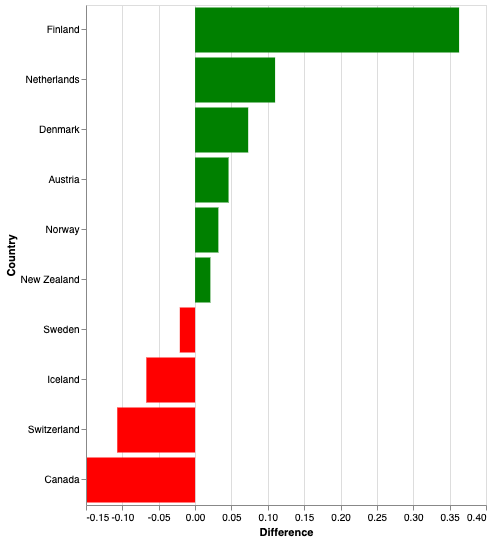

In [24]:
# Visualize the difference
bars = alt.Chart(top10_diff).mark_bar().encode(
    x='Difference:Q',
    y=alt.Y("Country:O",
            sort=alt.EncodingSortField(
            field="Difference",  
            order="descending")),  
    color=alt.condition(
        alt.datum.Difference > 0,
        alt.value("green"),  
        alt.value("red")  
    )
)

bars.properties(height=500,width=400)

Changes of happiness score for all countries

1. Benin's happiness score improved the most with over 1.4 points difference compared to 2014. 
2. Happiness in Venezuela dropped the most with over 2.2 points difference. 

In [25]:
hs_diff = (df[2018].iloc[:,3:6]
             .set_index('Happiness rank')
             .merge(df[2014][['Country','Happiness score']],
                  how='left',on='Country', suffixes=('_2018','_2014')))
hs_diff = hs_diff.assign(Difference=hs_diff['Happiness score_2018']-hs_diff['Happiness score_2014'])
hs_diff = hs_diff.dropna()
hs_diff = hs_diff.sort_values(by='Difference',ascending=False).reset_index(drop=True)

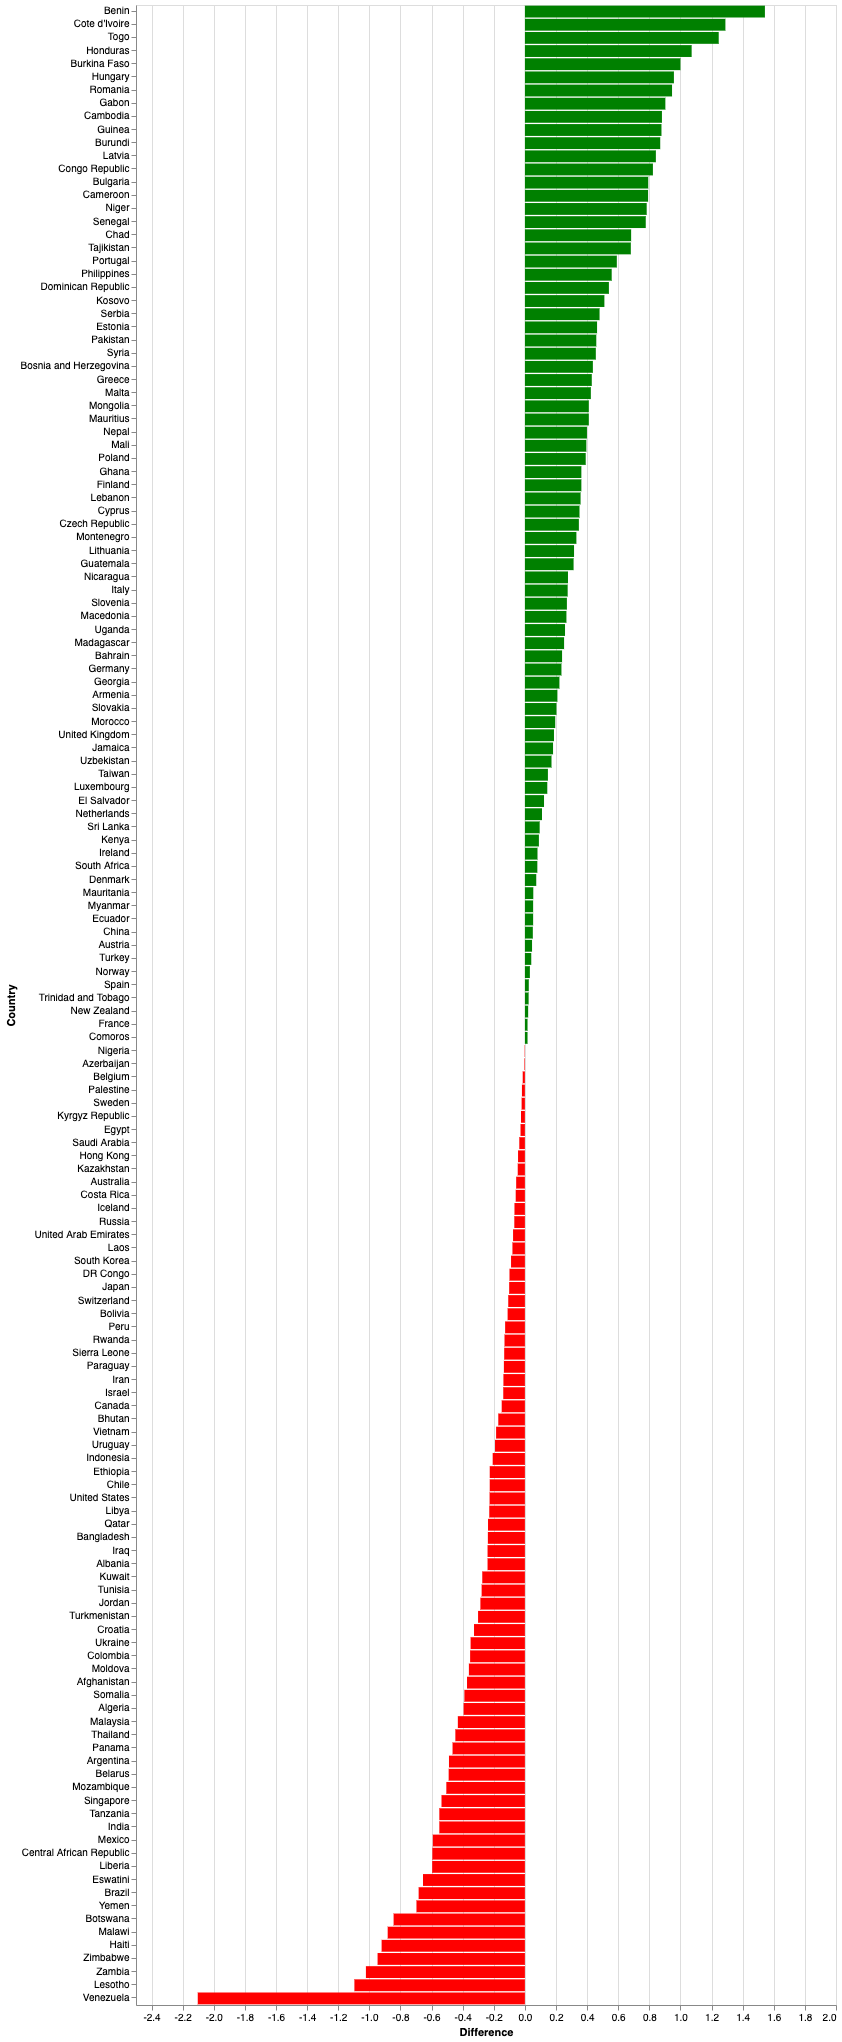

In [26]:
bars = alt.Chart(hs_diff).mark_bar().encode(
    x='Difference:Q',
    y=alt.Y("Country:O",
            sort=alt.EncodingSortField(
            field="Difference",    
            order="descending")),  
    color=alt.condition(
        alt.datum.Difference > 0,
        alt.value("green"),  
        alt.value("red")  
    )
)

(bars).properties(height=2000,width=700)

Top 10 gainers and losers

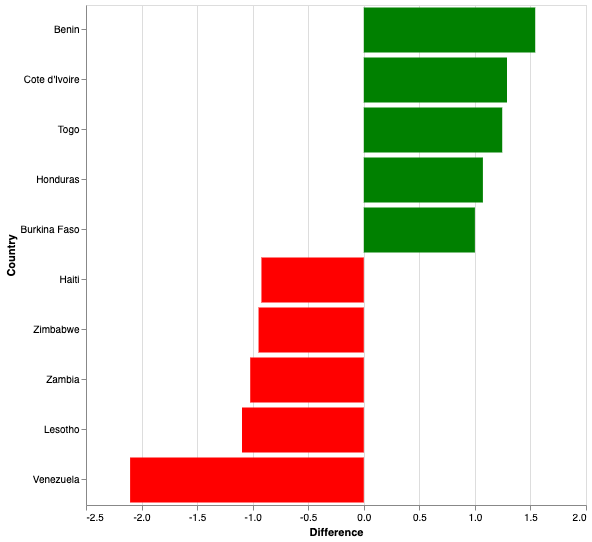

In [27]:
bars = alt.Chart(pd.concat([hs_diff.head(5),hs_diff.tail(5)])).mark_bar().encode(
    x='Difference:Q',
    y=alt.Y("Country:O",
            sort=alt.EncodingSortField(
            field="Difference",    
            order="descending")),
    color=alt.condition(
        alt.datum.Difference > 0,
        alt.value("green"),  
        alt.value("red")  
    )
)

(bars).properties(height=500,width=500)

## 2.2 Visualization on 2018 results



Obervations: 
1. The global average happiness score is 5.4, on a scale of 0 to 10 (happiest). 
2. 25% of the respondents rated their life satisfaction 6.1 or above. 
3. Amoung all the components, on avearge Social support contributed the most to happiness score, following by GDP per capita and Healthy life expectancy. 

In [28]:
df[2018].describe()

,Year,Happiness rank,Happiness score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,155.0,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,2018.0,78.593548,5.405090,0.902839,1.208535,0.723200,0.392413,0.184806,0.110271
std,0.0,45.308710,1.116445,0.398632,0.300141,0.241555,0.143740,0.095562,0.094753
min,2018.0,1.000000,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.0,39.500000,4.541000,0.594500,1.055500,0.544500,0.307000,0.108500,0.047000
50%,2018.0,79.000000,5.373000,0.960000,1.274000,0.789000,0.417000,0.177000,0.085000
75%,2018.0,117.500000,6.187000,1.226000,1.453000,0.881000,0.507500,0.249500,0.140500
max,2018.0,156.000000,7.769000,1.684000,1.624000,1.141000,0.631000,0.566000,0.453000


### 2.2.1-Distributions-of-happiness-score-in-regions

1. Northern Europe, Western Europe, Australia and New Zealand and Northern America performed the best with mean of happiness score over 7, on the scale of 0 to 10 (happiest). 
2. All African counties all had happiness score under avearge (5.4). Among the components, social support contributed the most to their happiness with a mean over 0.8 points. These might be explained by several factors including poor infrastructure, poor resource usage, wars and unending conflicts, etc.


In [29]:
# Select all columns except columns used to identify oberservations (i.e. year, country...)
cols = df[2018].columns[5:].tolist()
cols

['Happiness score',
 'GDP per capita',
 'Social support',
 'Healthy life expectancy',
 'Freedom to make life choices',
 'Generosity',
 'Perceptions of corruption']

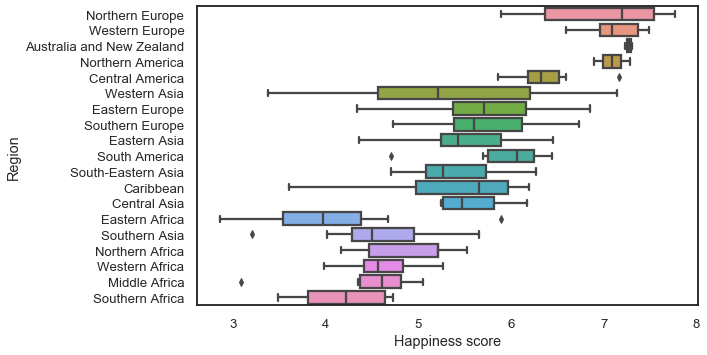

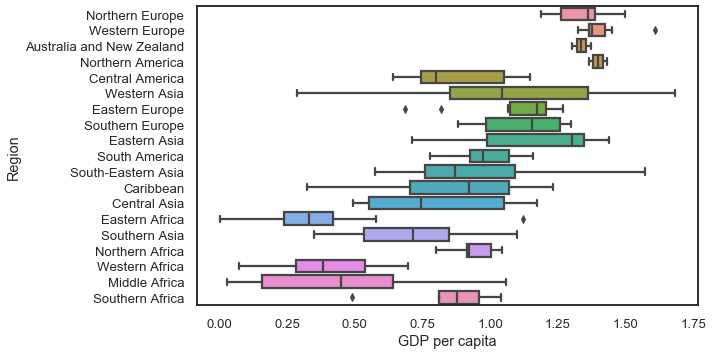

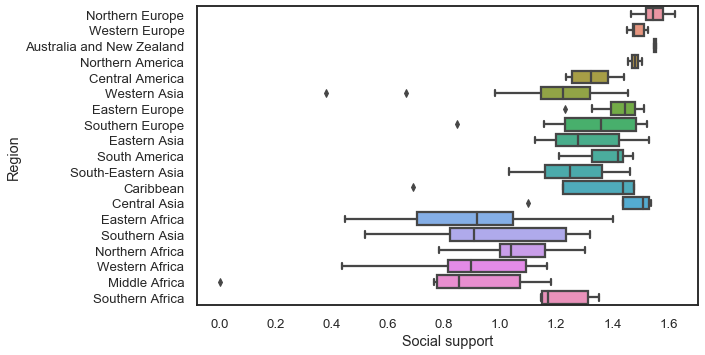

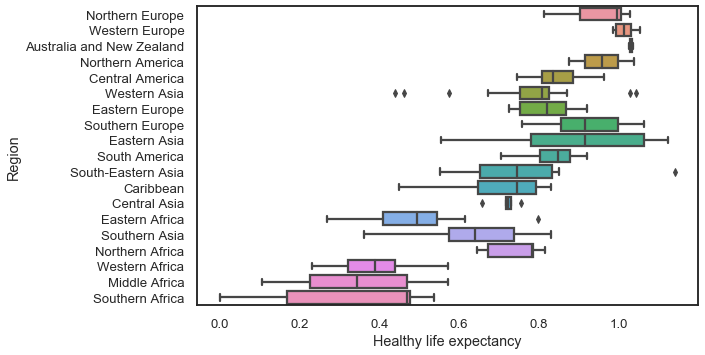

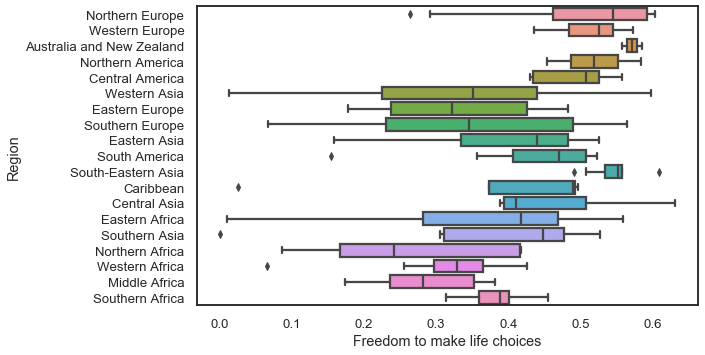

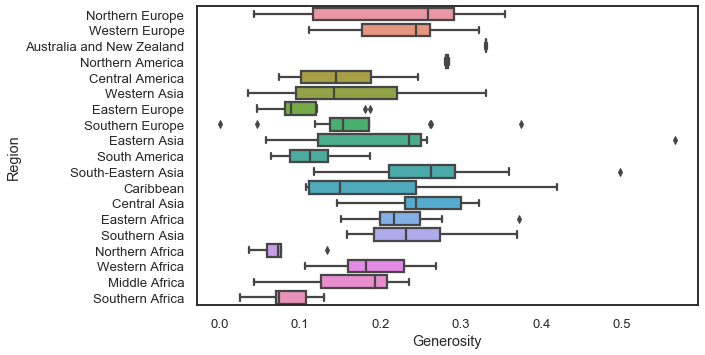

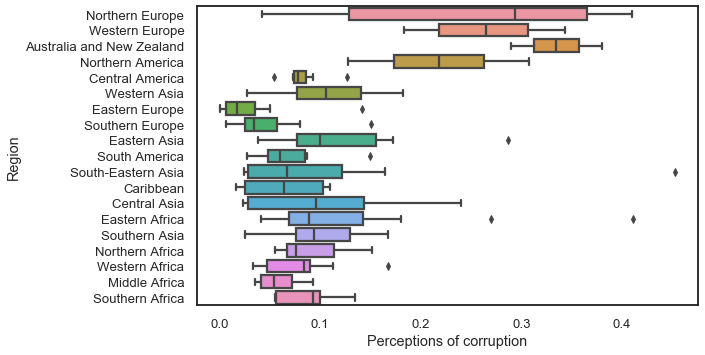

In [30]:
# Use Boxplots to visualize the distribution of happines score as well as each component among regions
for col in cols:
    fig,ax = plt.subplots(figsize=(8,5.5))
    g = sns.boxplot(x=col, y='Region', data=df[2018])
    plt.show()

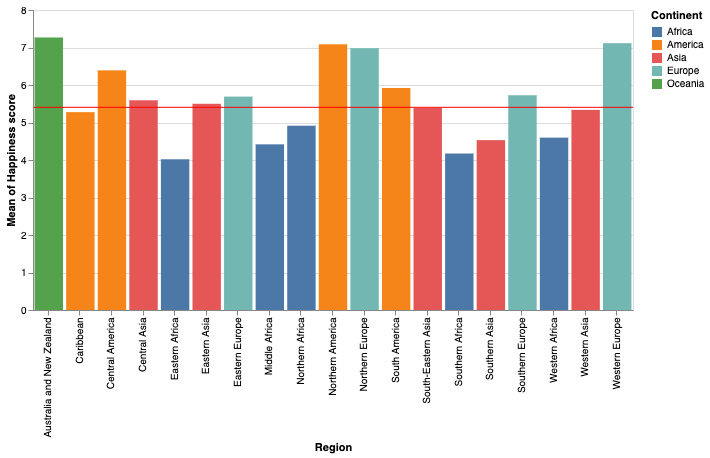

In [31]:
# Happiness Score comparison among regions

bar = alt.Chart(df[2018]).mark_bar().encode(x='Region:O',
                                            y='mean(Happiness score):Q',
                                            color='Continent:N')
rule = alt.Chart(df[2018]).mark_rule(color='red').encode(y='mean(Happiness score)')

(bar + rule).properties(width=600)


### 2.2.2-Relationships-between-components

Obervations:
- The importance of the following three components contributing on happiness score are clearly positive correlated:
  - GDP per capita
  - Healthy Life Expectancy
  - Social Support

In [32]:
# Plotly Scatterplot Matrix

cols = df[2018].columns[5:-1].tolist()

fig = ff.create_scatterplotmatrix(df[2018][cols],
                                  diag = 'box',
                                  index = 'Happiness score',
                                  colormap='Portland',
                                  colormap_type='cat',
                                  height=1200,
                                  width=1200)

fig.update_layout(title=go.layout.Title(
                                text='Scatterplot Matrix',
                                xref='paper',
                                x=0.5))

iplot(fig)

/Users/ivyip/miniconda3/envs/ironhack/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



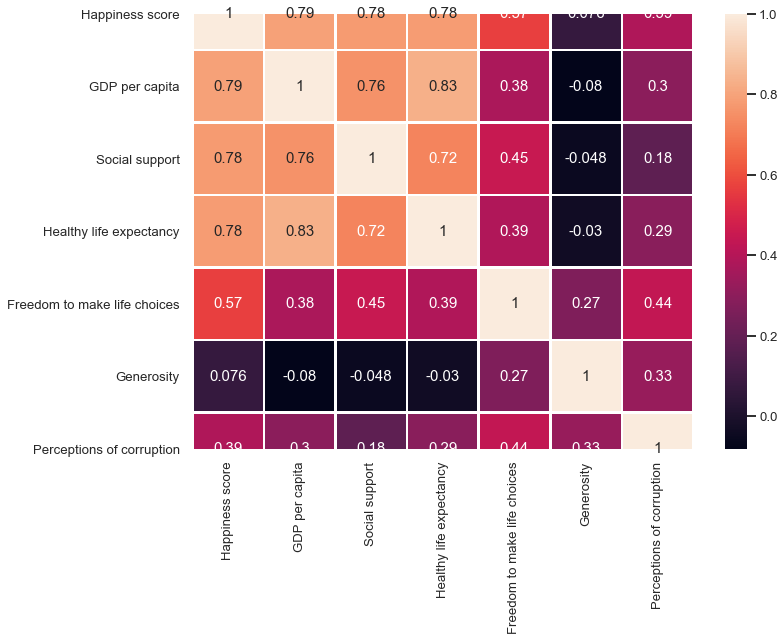

In [33]:
# Use heatmap to visualize the correlation between the components
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(df[2018].drop(columns=['Year','Happiness rank']).corr(), 
            annot=True,
            annot_kws={'size':15},
            linewidths=1.5,
            linecolor='white',
            ax=ax)
plt.show()

### 2.2.3-Happiness-on-Map

In [34]:
# Def function to use plotly choropleth map 
def plotly_choropleth_map(countries, values, title, 
                          colorbar_title, projection, colorscale):

    data=dict(
         type = 'choropleth',
         colorscale = colorscale,
         locations = countries,
         locationmode = 'country names',
         z = values,
         text = countries,
         colorbar = {'title' : colorbar_title})
    
    layout = dict(
             title = title,
             geo = dict(showframe = False,
                        projection = {'type' : projection}))
    
    choroplethmap = go.Figure(data = [data], layout=layout)
    choroplethmap.update_layout(title = go.layout.Title(text=title,
                                                        xref='paper',
                                                        x=1))
    
    iplot(choroplethmap)

In [35]:
# 2018 happiness score
plotly_choropleth_map(df[2014]['Country'],
                      df[2014]['Happiness score'],
                      'Happiness Score 2018',
                      'Happiness Score',
                      'natural earth',
                      'portland')


In [36]:
plotly_choropleth_map(df[2018]['Country'],
                      df[2018]['Freedom to make life choices'],
                      'How happy are the citizen regarding Freedom?',
                      'Calcaluted points',
                      'natural earth',
                      'peach')

In [37]:
plotly_choropleth_map(df[2018]['Country'],
                      df[2018]['Generosity'],
                      'How generous are the citizen?',
                      'Calculated points',
                      'natural earth',
                      'plasma')

## 3. Reshape and combine all dataframes




In [38]:
df_dict={}

for year in range(2014,2019):
    df[year].columns = map(str.lower,df[year].columns)
    df_dict[year]= df[year].filter(regex='(year|continent|region|country|rank|score)')
    df_all= pd.concat(df_dict.values(), ignore_index=True)

In [39]:
df_all

,year,continent,region,country,happiness rank,happiness score
0,2014,Europe,Western Europe,Switzerland,1,7.587
1,2014,Europe,Northern Europe,Iceland,2,7.561
2,2014,Europe,Northern Europe,Denmark,3,7.527
3,2014,Europe,Northern Europe,Norway,4,7.522
4,2014,America,Northern America,Canada,5,7.427
...,...,...,...,...,...,...
771,2018,Africa,Eastern Africa,Rwanda,152,3.334
772,2018,Africa,Eastern Africa,Tanzania,153,3.231
773,2018,Asia,Southern Asia,Afghanistan,154,3.203
774,2018,Africa,Middle Africa,Central African Republic,155,3.083


In [40]:
df_all.to_csv('./data/whi/df_all.csv', index=False)